# Segmentation
Unsupervised Learning

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
notebook_path = Path.cwd()
project_root = notebook_path.parent
sys.path.insert(0, str(project_root))

# print(f"Project Root (added to sys.path): {project_root}")

In [3]:
from src import config
from src.data_loader import load_census_data

raw_df = load_census_data(
    data_path=config.DATA_FILE,
    columns_path=config.COLUMNS_FILE
)
raw_df.head()

Data loaded and initial cleaning complete.
Dataset shape: (199523, 42)


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


In [4]:
print(config.TARGET_VARIABLE)

label


Separate the Target, Features and Weights

In [5]:
X = raw_df.drop(columns=[config.TARGET_VARIABLE, 'weight'])
y = raw_df[config.TARGET_VARIABLE]
weights = raw_df['weight']

Feature Engineering

In [6]:
from src.feature_engineering import create_features

X_featured = create_features(X)

print(X_featured.shape[1])
print(X_featured.columns.tolist())

Mapping numeric codes to string labels...
Dropping unused columns: ['detailed_industry_recode', 'detailed_occupation_recode', 'year']
Feature engineering complete. New columns added.
46
['age', 'class_of_worker', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenshi

## Feature Selection

In [ ]:
SEGMENTATION_FEATURES = [
    # Core Demographics
    'age', 'sex', 'race',
    # Household Composition
    'marital_stat', 'family_members_under_18', 'tax_filer_stat',
    # Education & Careers
    'education_group', 'major_occupation_code', 'major_industry_code',
    # Work Intensity
    'employment_status', 'weeks_worked_in_year',
    # Financial Profile
    'wage_per_hour', 'capital_gains', 'capital_losses', 'dividends_from_stocks',
    'has_investment_income', 'own_business_or_self_employed',
    # Nativity & Migration
    'citizenship', 'live_in_this_house_1_year_ago',
    # Veteran Status
    'veterans_benefits'
]

X_segment = X_featured[SEGMENTATION_FEATURES].copy()
SEG_NUMERICAL_COLS = X_segment.select_dtypes(include=np.number).columns.tolist()
SEG_CATEGORICAL_COLS = X_segment.select_dtypes(include=['object', 'category']).columns.tolist()

In [19]:
print(f"Numerical Features ({len(SEG_NUMERICAL_COLS)}): {SEG_NUMERICAL_COLS}")
print(f"Categorical Features ({len(SEG_CATEGORICAL_COLS)}): {SEG_CATEGORICAL_COLS}")

Numerical Features (7): ['age', 'weeks_worked_in_year', 'wage_per_hour', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'has_investment_income']
Categorical Features (13): ['sex', 'race', 'marital_stat', 'family_members_under_18', 'tax_filer_stat', 'education_group', 'major_occupation_code', 'major_industry_code', 'employment_status', 'own_business_or_self_employed', 'citizenship', 'live_in_this_house_1_year_ago', 'veterans_benefits']


## Preprocessing 
### with FAMD

In [22]:
import prince

famd_preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), SEG_NUMERICAL_COLS)],
    remainder='passthrough'
)
famd_preprocessor.set_output(transform='pandas')

N_COMPONENTS = 15

famd_pipeline = Pipeline(steps=[
    ('preprocessor', famd_preprocessor),
    ('famd', prince.FAMD(
        n_components=N_COMPONENTS,
        n_iter=5,
        random_state=config.RANDOM_STATE
    ))
])

print("Fitting FAMD and transforming data...")
X_processed_famd = famd_pipeline.fit_transform(X_segment)
print(f"Processed Feature Shape after FAMD: {X_processed_famd.shape}")


Fitting FAMD and transforming data...
Processed Feature Shape after FAMD: (199523, 15)


In [30]:
famd_instance = famd_pipeline.named_steps['famd']
famd_instance.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,36.528,7.39%,7.39%
1,13.651,2.76%,10.15%
2,13.142,2.66%,12.81%
3,13.021,2.63%,15.44%
4,12.688,2.57%,18.00%
5,12.160,2.46%,20.46%
6,11.722,2.37%,22.83%
7,10.247,2.07%,24.91%
8,9.837,1.99%,26.90%


In [38]:
eigenvalues = famd_instance.eigenvalues_
total_inertia = sum(eigenvalues)
explained_inertia = [eig / total_inertia for eig in eigenvalues]

feature_contributions = famd_instance.column_coordinates_

# --- Detailed Analysis for Top Components ---

print("="*60)
print("--- Decoding FAMD Component 0 (The Primary Axis) ---")
print(f"This component explains {explained_inertia[0]:.2%} of the total variance.")
print("Top 10 features most influential for Component 0:")
# We display the actual coordinate values to see the direction of influence (positive/negative)
# but sort by the absolute value to find the strongest influencers.
display(feature_contributions[0].reindex(feature_contributions[0].abs().sort_values(ascending=False).index).head(10).to_frame(name='Coordinate on Component 0'))


print("\n" + "="*60)
print("--- Decoding FAMD Component 1 (The Secondary Axis) ---")
print(f"This component explains {explained_inertia[1]:.2%} of the total variance.")
print("Top 10 features most influential for Component 1:")
display(feature_contributions[1].reindex(feature_contributions[1].abs().sort_values(ascending=False).index).head(10).to_frame(name='Coordinate on Component 1'))


max_val = feature_contributions.abs().max().max()

# Apply the background gradient styling
styled_contributions = feature_contributions.style.background_gradient(
    cmap='bwr', vmin=-max_val, vmax=max_val
).format("{:.3f}")

print("\nFull Contribution Matrix of Features on FAMD Components:")
display(styled_contributions)

--- Decoding FAMD Component 0 (The Primary Axis) ---
This component explains 19.72% of the total variance.
Top 10 features most influential for Component 0:


,Coordinate on Component 0
variable,
remainder__education_group,0.827275
remainder__tax_filer_stat,0.784820
remainder__family_members_under_18,0.782623
remainder__veterans_benefits,0.763365
remainder__major_occupation_code,0.685969
remainder__major_industry_code,0.684872
scaler__weeks_worked_in_year,0.629978
remainder__marital_stat,0.505305
scaler__age,0.331611



--- Decoding FAMD Component 1 (The Secondary Axis) ---
This component explains 7.37% of the total variance.
Top 10 features most influential for Component 1:


,Coordinate on Component 1
variable,
remainder__major_occupation_code,0.566244
remainder__major_industry_code,0.463641
remainder__education_group,0.384369
remainder__tax_filer_stat,0.265474
remainder__marital_stat,0.250778
scaler__has_investment_income,0.039601
remainder__citizenship,0.038717
remainder__veterans_benefits,0.032360
remainder__race,0.027605



Full Contribution Matrix of Features on FAMD Components:


component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
variable,,,,,,,,,,,,,,,
scaler__age,0.332,0.007,0.235,0.007,0.068,0.042,0.009,0.001,0.009,0.009,0.000,0.017,0.032,0.000,0.000
scaler__weeks_worked_in_year,0.630,0.006,0.078,0.001,0.022,0.013,0.003,0.000,0.001,0.000,0.002,0.010,0.009,0.000,0.000
scaler__wage_per_hour,0.031,0.000,0.006,0.000,0.004,0.000,0.003,0.002,0.001,0.002,0.000,0.001,0.000,0.001,0.000
scaler__capital_gains,0.007,0.009,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.003,0.001,0.000,0.000,0.000,0.000
scaler__capital_losses,0.011,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.004,0.000,0.000,0.000,0.000,0.000
scaler__dividends_from_stocks,0.003,0.004,0.002,0.000,0.003,0.000,0.000,0.000,0.000,0.003,0.001,0.000,0.002,0.000,0.000
scaler__has_investment_income,0.075,0.040,0.004,0.000,0.008,0.000,0.000,0.002,0.002,0.010,0.007,0.000,0.005,0.000,0.000
remainder__citizenship,0.014,0.039,0.019,0.000,0.014,0.011,0.002,0.068,0.189,0.008,0.009,0.040,0.140,0.083,0.068
remainder__education_group,0.827,0.384,0.170,0.002,0.095,0.074,0.029,0.103,0.053,0.152,0.029,0.050,0.020,0.032,0.040


Find Optimal Number of Clusters

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

sample_indices = np.random.choice(X_processed_famd.shape[0], config.SAMPLE_SIZE_FOR_K_SELECTION, replace=False)
X_sample_famd = X_processed_famd.iloc[sample_indices]

metrics = []
k_list = config.K_CANDIDATES
print(f"Starting k-selection for k in {k_list} on FAMD components...")
for k in k_list:
    km = MiniBatchKMeans(n_clusters=k,
                         n_init='auto',
                         batch_size=config.KMEANS_BATCH_SIZE,
                         random_state=config.RANDOM_STATE)
    labels = km.fit_predict(X_sample_famd)
    sil = silhouette_score(X_sample_famd, labels)
    dbi = davies_bouldin_score(X_sample_famd, labels)
    metrics.append({"k": k, "silhouette": sil, "davies_bouldin": dbi})
    print(f"  k={k}: Silhouette={sil:.4f}, Davies-Bouldin={dbi:.4f}")

metrics_df = pd.DataFrame(metrics)

Starting k-selection for k in [3, 4, 5, 6, 7, 8, 9, 10, 12, 15] on FAMD components...
  k=3: Silhouette=0.2004, Davies-Bouldin=2.1469
  k=4: Silhouette=0.2118, Davies-Bouldin=2.0870
  k=5: Silhouette=0.2195, Davies-Bouldin=2.0481
  k=6: Silhouette=0.2468, Davies-Bouldin=1.8244
  k=7: Silhouette=0.2643, Davies-Bouldin=1.6660
  k=8: Silhouette=0.1831, Davies-Bouldin=1.6535
  k=9: Silhouette=0.1968, Davies-Bouldin=1.7201
  k=10: Silhouette=0.2658, Davies-Bouldin=1.4638
  k=12: Silhouette=0.1969, Davies-Bouldin=1.5321
  k=15: Silhouette=0.3095, Davies-Bouldin=1.3838


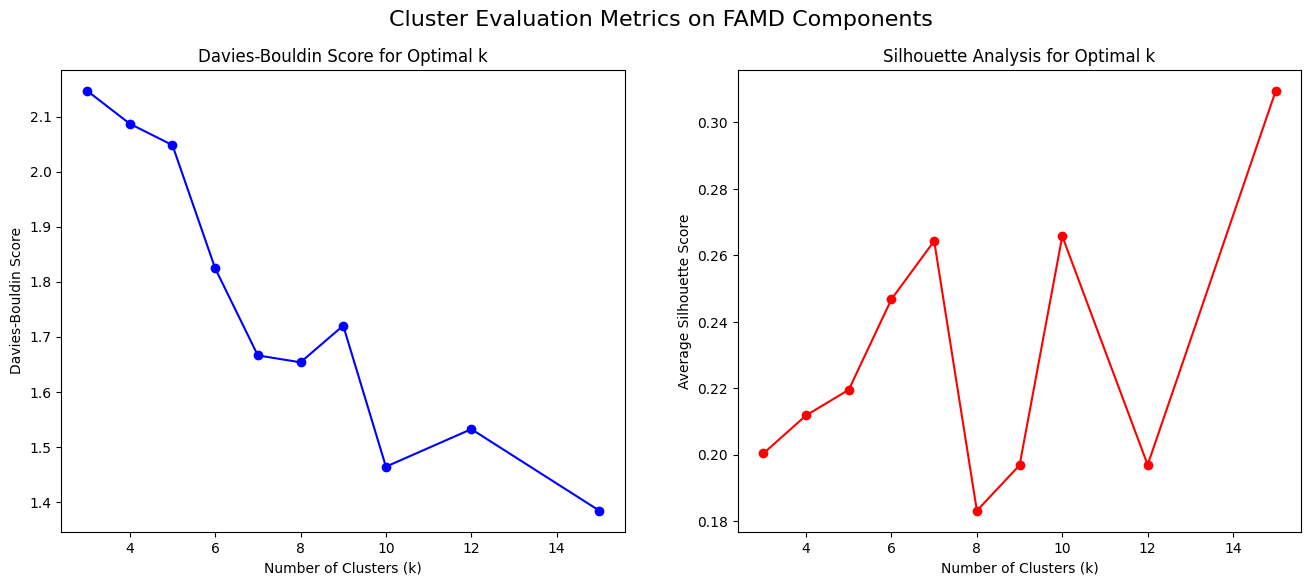

In [ ]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Cluster Evaluation Metrics on FAMD Components', fontsize=16)

# Davies-Bouldin Score Plot (Elbow Method) - Lower is better
ax1.plot(metrics_df['k'], metrics_df['davies_bouldin'], 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Davies-Bouldin Score')
ax1.set_title('Davies-Bouldin Score for Optimal k')

# Silhouette Score Plot - Higher is better
ax2.plot(metrics_df['k'], metrics_df['silhouette'], 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Average Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k')

plt.show()


### Compare with Truncated SVD for Dimension Reduction

In [39]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder

# %% [markdown]
# ### 1. Create the TruncatedSVD Preprocessing Pipeline
# This pipeline will scale numerical features and one-hot encode categorical features.

# %%
# Define the preprocessor for SVD
svd_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), SEG_NUMERICAL_COLS),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), SEG_CATEGORICAL_COLS)
    ],
    remainder='passthrough'
)

# Define the full pipeline with TruncatedSVD
N_COMPONENTS = 15 # Let's use the same number of components for a fair comparison

svd_pipeline = Pipeline(steps=[
    ('preprocessor', svd_preprocessor),
    ('svd', TruncatedSVD(
        n_components=N_COMPONENTS,
        random_state=config.RANDOM_STATE
    ))
])

# Fit the pipeline
print("Fitting TruncatedSVD pipeline...")
X_processed_svd = svd_pipeline.fit_transform(X_segment)
print(f"Shape of data after SVD: {X_processed_svd.shape}")

Fitting TruncatedSVD pipeline...
Shape of data after SVD: (199523, 15)


In [40]:
# Get the fitted preprocessor and SVD model from the pipeline
preprocessor_fitted = svd_pipeline.named_steps['preprocessor']
svd_model = svd_pipeline.named_steps['svd']

# Get the feature names after preprocessing (this is crucial)
# The get_feature_names_out() method provides the names of the scaled and OHE columns
feature_names_out = preprocessor_fitted.get_feature_names_out()

# Create a DataFrame of the component loadings (weights)
# The .components_ attribute has a shape of (n_components, n_features)
component_loadings = pd.DataFrame(
    svd_model.components_.T, # Transpose to have features as rows
    index=feature_names_out,
    columns=[f"Component {i}" for i in range(N_COMPONENTS)]
)

print("\n--- Decoding TruncatedSVD Component 0 ---")
print("Top 10 influential features (absolute value):")
display(component_loadings['Component 0'].reindex(component_loadings['Component 0'].abs().sort_values(ascending=False).index).head(10).to_frame())


print("\n--- Decoding TruncatedSVD Component 1 ---")
print("Top 10 influential features (absolute value):")
display(component_loadings['Component 1'].reindex(component_loadings['Component 1'].abs().sort_values(ascending=False).index).head(10).to_frame())


--- Decoding TruncatedSVD Component 0 ---
Top 10 influential features (absolute value):


,Component 0
ohe__citizenship_Native- Born in the United States,0.400391
ohe__race_White,0.377223
ohe__employment_status_not-in-labor-force,0.360824
ohe__family_members_under_18_Not in universe,0.291629
ohe__major_occupation_code_Not in universe,0.265010
ohe__major_industry_code_Not in universe or children,0.265010
ohe__sex_Male,0.218111
ohe__live_in_this_house_1_year_ago_Not in universe under 1 year old,0.216936
ohe__marital_stat_Never married,0.211024
ohe__tax_filer_stat_Nonfiler,0.198019



--- Decoding TruncatedSVD Component 1 ---
Top 10 influential features (absolute value):


,Component 1
scaler__weeks_worked_in_year,0.471084
scaler__age,0.408916
ohe__family_members_under_18_Not in universe,0.299232
scaler__has_investment_income,0.295881
ohe__marital_stat_Married-civilian spouse present,0.230742
ohe__tax_filer_stat_Nonfiler,-0.211835
ohe__tax_filer_stat_Joint both under 65,0.201442
ohe__education_group_Children,-0.184850
ohe__veterans_benefits_Not in universe,-0.184815
ohe__marital_stat_Never married,-0.178427


In [41]:
# --- Full Styled Loading Matrix ---
max_val = component_loadings.abs().max().max()

styled_svd_loadings = component_loadings.style.background_gradient(
    cmap='bwr', vmin=-max_val, vmax=max_val
).format("{:.3f}")

print("\nFull Loading Matrix for TruncatedSVD Components:")
display(styled_svd_loadings)



Full Loading Matrix for TruncatedSVD Components:


,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11,Component 12,Component 13,Component 14
scaler__age,-0.028,0.409,0.141,0.590,-0.084,0.165,0.258,-0.110,0.062,0.187,0.099,0.035,0.099,-0.243,-0.285
scaler__weeks_worked_in_year,-0.080,0.471,-0.302,-0.296,0.009,-0.231,-0.268,-0.051,-0.081,0.099,-0.008,0.020,-0.037,-0.111,-0.378
scaler__wage_per_hour,-0.022,0.147,-0.279,-0.417,-0.122,0.752,0.378,0.029,0.016,-0.020,0.000,-0.012,0.005,0.007,-0.004
scaler__capital_gains,-0.008,0.126,0.449,-0.413,-0.203,-0.378,0.542,-0.364,0.000,0.003,-0.030,-0.000,0.000,-0.002,0.017
scaler__capital_losses,-0.009,0.103,-0.018,-0.029,0.950,-0.032,0.285,-0.021,0.005,-0.034,-0.034,0.002,-0.012,0.016,0.007
scaler__dividends_from_stocks,-0.003,0.117,0.553,-0.140,0.157,0.413,-0.532,-0.426,-0.009,-0.027,0.003,0.001,-0.006,0.008,0.001
scaler__has_investment_income,-0.019,0.296,0.480,-0.139,-0.005,0.025,-0.021,0.801,0.003,0.054,-0.009,0.018,-0.055,0.077,0.032
ohe__sex_Male,0.218,0.068,-0.036,-0.105,0.038,-0.055,-0.036,0.009,0.023,0.053,0.890,0.113,0.113,-0.143,0.183
ohe__race_Asian or Pacific Islander,0.010,-0.000,-0.001,-0.002,0.000,-0.002,-0.000,-0.002,0.004,-0.008,0.025,-0.006,-0.086,-0.004,0.004
ohe__race_Black,0.041,-0.013,-0.012,-0.004,-0.002,0.003,0.005,-0.019,0.004,0.041,0.067,0.043,-0.617,-0.103,-0.106


Find Optimal Number of Clusters

In [43]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

sample_indices = np.random.choice(X_processed_svd.shape[0], config.SAMPLE_SIZE_FOR_K_SELECTION, replace=False)
X_sample_svd = X_processed_svd[sample_indices]

metrics = []
k_list = config.K_CANDIDATES
print(f"Starting k-selection for k in {k_list} on SVD components...")
for k in k_list:
    km = MiniBatchKMeans(n_clusters=k,
                         n_init='auto',
                         batch_size=config.KMEANS_BATCH_SIZE,
                         random_state=config.RANDOM_STATE)
    labels = km.fit_predict(X_sample_svd)
    sil = silhouette_score(X_sample_svd, labels)
    dbi = davies_bouldin_score(X_sample_svd, labels)
    metrics.append({"k": k, "silhouette": sil, "davies_bouldin": dbi})
    print(f"  k={k}: Silhouette={sil:.4f}, Davies-Bouldin={dbi:.4f}")

metrics_df = pd.DataFrame(metrics)

Starting k-selection for k in [3, 4, 5, 6, 7, 8, 9, 10, 12, 15] on SVD components...
  k=3: Silhouette=0.2855, Davies-Bouldin=1.5522
  k=4: Silhouette=0.3067, Davies-Bouldin=1.5213
  k=5: Silhouette=0.3199, Davies-Bouldin=1.3165
  k=6: Silhouette=0.3423, Davies-Bouldin=1.1572
  k=7: Silhouette=0.3151, Davies-Bouldin=1.2622
  k=8: Silhouette=0.2964, Davies-Bouldin=1.4706
  k=9: Silhouette=0.2236, Davies-Bouldin=1.5541
  k=10: Silhouette=0.2405, Davies-Bouldin=1.3624
  k=12: Silhouette=0.2335, Davies-Bouldin=1.4832
  k=15: Silhouette=0.2436, Davies-Bouldin=1.4873


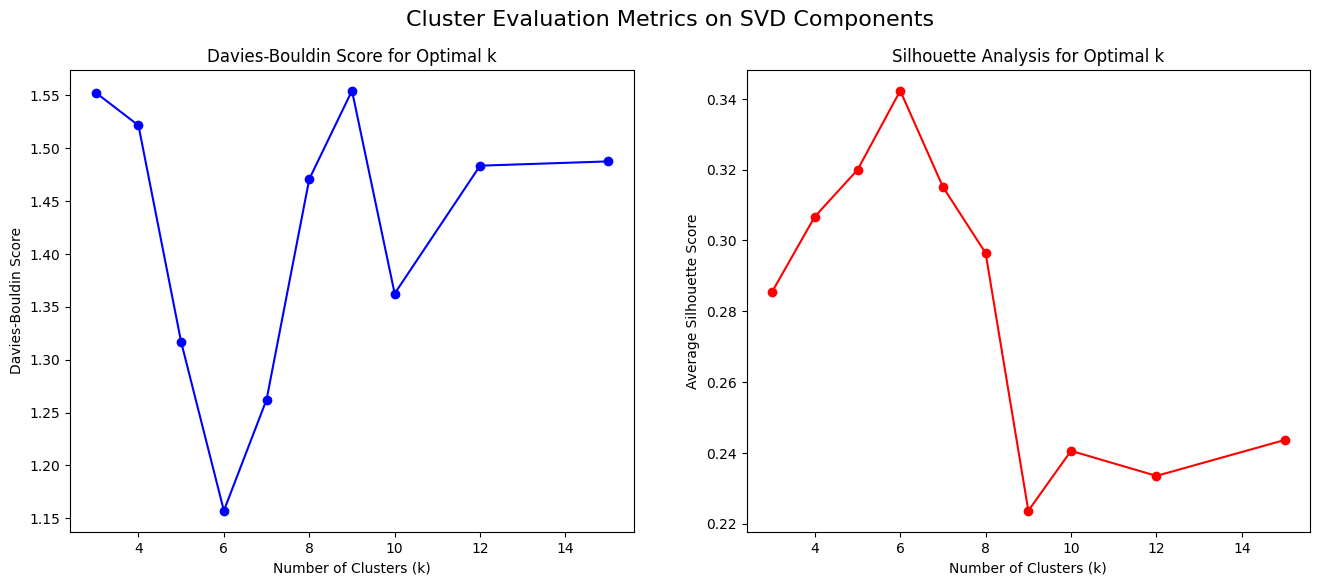

In [45]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Cluster Evaluation Metrics on SVD Components', fontsize=16)

# Davies-Bouldin Score Plot (Elbow Method) - Lower is better
ax1.plot(metrics_df['k'], metrics_df['davies_bouldin'], 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Davies-Bouldin Score')
ax1.set_title('Davies-Bouldin Score for Optimal k')

# Silhouette Score Plot - Higher is better
ax2.plot(metrics_df['k'], metrics_df['silhouette'], 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Average Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k')

plt.show()


In [46]:
OPTIMAL_K = 6 # Based on the analysis above

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=config.RANDOM_STATE, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_processed_svd)

# Add the cluster labels back to our original (pre-processed) segmentation data
X_segment['cluster'] = cluster_labels
print(f"Final cluster assignments (for k={OPTIMAL_K}):")
print(X_segment['cluster'].value_counts())

Final cluster assignments (for k=6):
cluster
1    74870
0    59949
2    35450
4    25062
5     3802
3      390
Name: count, dtype: int64


/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_86007/1193895757.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_segment['cluster'] = cluster_labels


Interprete the Result

In [48]:
# Calculate the mean of numerical features for each cluster
numerical_summary = X_segment.groupby('cluster')[SEG_NUMERICAL_COLS].mean()
# Calculate the mean for the total population for comparison
total_mean = X_segment[SEG_NUMERICAL_COLS].mean()
numerical_summary.loc['Total_Mean'] = total_mean

# Display the summary table, transposing for easier reading
print("Mean of Numerical Features by Cluster:")
display(numerical_summary.T)

Mean of Numerical Features by Cluster:


cluster,0,1,2,3,4,5,Total_Mean
age,9.358405,37.444838,59.102200,46.869231,49.365454,43.980800,34.494199
weeks_worked_in_year,0.551435,46.504768,1.437772,47.458974,35.158686,41.670174,23.174897
wage_per_hour,1.486564,116.349392,0.844908,24.833333,76.492938,79.443188,55.426908
capital_gains,0.000000,0.000000,0.000000,99999.000000,1904.749302,0.000000,434.718990
capital_losses,0.000000,0.434660,0.453738,0.000000,0.320525,1943.266176,37.313788
dividends_from_stocks,0.016914,0.000668,0.000000,4861.033333,1386.425305,728.097580,197.529533
has_investment_income,0.000183,0.000013,0.000000,1.000000,1.000000,0.253288,0.132451


In [54]:
numerical_summary.T

cluster,0,1,2,3,4,5,Total_Mean
age,9.358405,37.444838,59.102200,46.869231,49.365454,43.980800,34.494199
weeks_worked_in_year,0.551435,46.504768,1.437772,47.458974,35.158686,41.670174,23.174897
wage_per_hour,1.486564,116.349392,0.844908,24.833333,76.492938,79.443188,55.426908
capital_gains,0.000000,0.000000,0.000000,99999.000000,1904.749302,0.000000,434.718990
capital_losses,0.000000,0.434660,0.453738,0.000000,0.320525,1943.266176,37.313788
dividends_from_stocks,0.016914,0.000668,0.000000,4861.033333,1386.425305,728.097580,197.529533
has_investment_income,0.000183,0.000013,0.000000,1.000000,1.000000,0.253288,0.132451


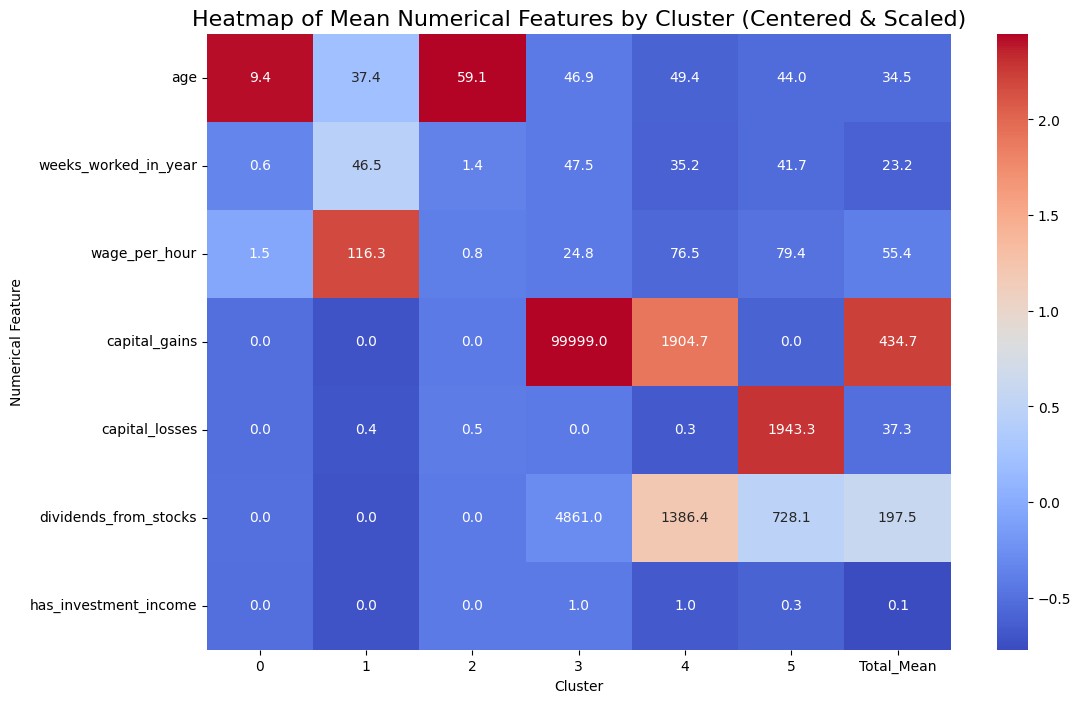

In [57]:
# Normalize the data for fair comparison in the heatmap
scaler = StandardScaler()

# Ensure all column names and index are strings
numerical_summary.columns = numerical_summary.columns.astype(str)
numerical_summary.index = numerical_summary.index.astype(str)

summary_scaled = scaler.fit_transform(numerical_summary.T)  # Transpose to scale features
plt.figure(figsize=(12, 8))
sns.heatmap(
    summary_scaled,
    annot=numerical_summary.T,
    fmt=".1f",
    cmap="coolwarm",
    yticklabels=numerical_summary.columns,
    xticklabels=numerical_summary.index
)
plt.title('Heatmap of Mean Numerical Features by Cluster (Centered & Scaled)', fontsize=16)
plt.ylabel('Numerical Feature')
plt.xlabel('Cluster')
plt.show()



----- Distribution of 'sex' by Cluster -----


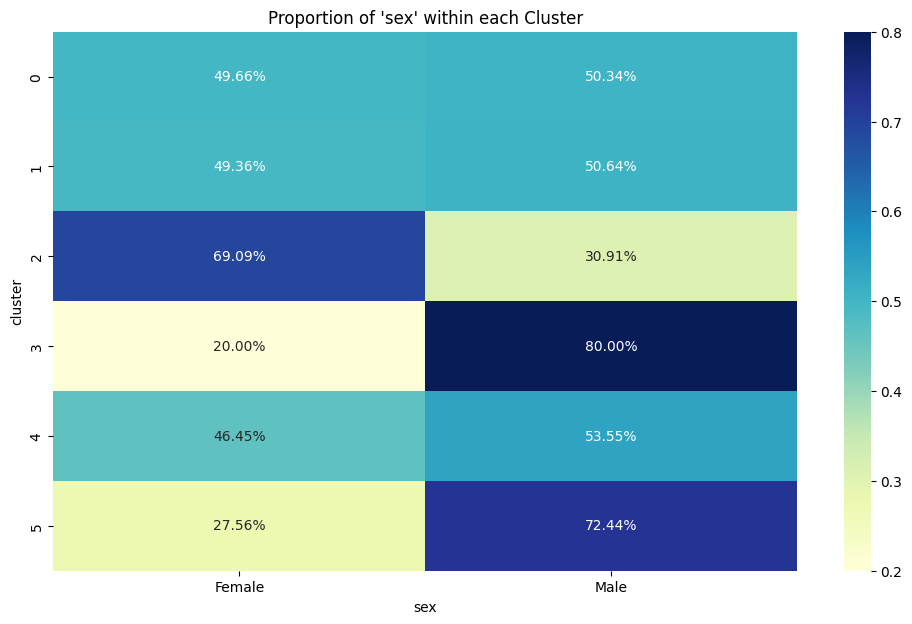

AttributeError: module 'src.config' has no attribute 'FIGURE_DIR'

In [ ]:
# Analyze the distribution of categorical features across clusters
for col in SEG_CATEGORICAL_COLS:
    # Use crosstab to get a frequency table
    contingency_table = pd.crosstab(
        index=X_segment['cluster'],
        columns=X_segment[col],
        normalize='index' # Normalize by row to get percentages
    )
    print(f"\n----- Distribution of '{col}' by Cluster -----")
    # Plotting the distributions
    plt.figure(figsize=(12, 7))
    # Use a diverging color palette to highlight differences from a central point
    sns.heatmap(contingency_table, annot=True, fmt=".2%", cmap="YlGnBu")
    plt.title(f"Proportion of '{col}' within each Cluster")
    plt.show()
    # plt.savefig(os.path.join(config.FIGURE_DIR, f"categorical_distribution_{col}.png"))